In [1]:
import numpy as np
import math
import torch
import torchvision.transforms as T
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import gc

/home/dguillory/anaconda3/envs/elbiat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform
    

In [3]:
def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

In [4]:
def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

In [5]:
def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values


In [6]:
from PIL import Image
import requests
from io import BytesIO

def load_image_from_url(image_url, input_size=448, max_num=12):
    headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"}
    
    response = requests.get(image_url, headers=headers)
    #print(response.content)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [7]:
def split_model(model_name):
    device_map = {}
    world_size = torch.cuda.device_count()
    num_layers = {
        'InternVL2_5-1B': 24, 'InternVL2_5-2B': 24, 'InternVL2_5-4B': 36, 'InternVL2_5-8B': 32,
        'InternVL2_5-26B': 48, 'InternVL2_5-38B': 64, 'InternVL2_5-78B': 80}[model_name]
    # Since the first GPU will be used for ViT, treat it as half a GPU.
    num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
    num_layers_per_gpu = [num_layers_per_gpu] * world_size
    num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
    layer_cnt = 0
    for i, num_layer in enumerate(num_layers_per_gpu):
        for j in range(num_layer):
            device_map[f'language_model.model.layers.{layer_cnt}'] = i
            layer_cnt += 1
    device_map['vision_model'] = 0
    device_map['mlp1'] = 0
    device_map['language_model.model.tok_embeddings'] = 0
    device_map['language_model.model.embed_tokens'] = 0
    device_map['language_model.model.rotary_emb'] = 0
    device_map['language_model.output'] = 0
    device_map['language_model.model.norm'] = 0
    device_map['language_model.lm_head'] = 0
    device_map[f'language_model.model.layers.{num_layers - 1}'] = 0

    return device_map

In [8]:
world_size = torch.cuda.device_count()
print(world_size)

6


In [9]:
def print_gpu_memory():
    allocated = torch.cuda.memory_allocated() / 1024**3
    reserved = torch.cuda.memory_reserved() / 1024**3
    print(f"Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")

In [10]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

In [11]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 0.00 GB, Reserved: 0.00 GB
Allocated: 0.00 GB, Reserved: 0.00 GB


In [12]:
# If you have an 80G A100 GPU, you can put the entire model on a single GPU.
# Otherwise, you need to load a model using multiple GPUs, please refer to the `Multiple GPUs` section.


path = 'OpenGVLab/InternVL2_5-8B'
device_map = split_model('InternVL2_5-8B')

model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True,
    device_map=device_map).eval()
"""
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    device_map=device_map).eval().cuda()
"""


tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)


InternLM2ForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


FlashAttention2 is not installed.


Loading checkpoint shards: 100%|████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/it]


In [13]:
print(device_map)

{'language_model.model.layers.0': 0, 'language_model.model.layers.1': 0, 'language_model.model.layers.2': 0, 'language_model.model.layers.3': 1, 'language_model.model.layers.4': 1, 'language_model.model.layers.5': 1, 'language_model.model.layers.6': 1, 'language_model.model.layers.7': 1, 'language_model.model.layers.8': 1, 'language_model.model.layers.9': 2, 'language_model.model.layers.10': 2, 'language_model.model.layers.11': 2, 'language_model.model.layers.12': 2, 'language_model.model.layers.13': 2, 'language_model.model.layers.14': 2, 'language_model.model.layers.15': 3, 'language_model.model.layers.16': 3, 'language_model.model.layers.17': 3, 'language_model.model.layers.18': 3, 'language_model.model.layers.19': 3, 'language_model.model.layers.20': 3, 'language_model.model.layers.21': 4, 'language_model.model.layers.22': 4, 'language_model.model.layers.23': 4, 'language_model.model.layers.24': 4, 'language_model.model.layers.25': 4, 'language_model.model.layers.26': 4, 'language_

In [14]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.73 GB, Reserved: 3.79 GB
Allocated: 3.73 GB, Reserved: 3.79 GB


In [15]:
# set the max number of tiles in `max_num`
pixel_values = load_image('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=False)




In [16]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.75 GB, Reserved: 3.80 GB
Allocated: 3.75 GB, Reserved: 3.80 GB


In [17]:
# pure-text conversation (纯文本对话)
question = 'Hello, who are you?'
response, history = model.chat(tokenizer, None, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: Hello, who are you?
Assistant: Hello! I am an AI assistant whose name is InternVL, developed jointly by Shanghai AI Lab, Tsinghua University and other partners.


In [18]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.75 GB, Reserved: 3.85 GB
Allocated: 3.75 GB, Reserved: 3.80 GB


In [19]:
question = 'Can you tell me a story?'
response, history = model.chat(tokenizer, None, question, generation_config, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')



User: Can you tell me a story?
Assistant: Of course! Here's a story for you:

Once upon a time, in a small village nestled in the heart of a dense forest, there lived a young girl named Elara. Elara was known throughout the village for her kind heart and her love for nature. She spent most of her days exploring the forest, discovering new plants, and befriending the animals that lived there.

One day, while wandering deeper into the forest than she had ever been before, Elara stumbled upon a hidden clearing. In the center of the clearing stood an enormous tree, its branches reaching up to the sky. The tree was unlike any she had ever seen before; its bark was a deep, rich brown, and its leaves shimmered in the sunlight.

As Elara approached the tree, she noticed that it was not alone. A small, delicate fairy was perched on one of the lower branches. The fairy, whose name was Luna, was the guardian of the forest. She had been watching Elara from afar, impressed by her kindness and her l

In [20]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.75 GB, Reserved: 3.88 GB
Allocated: 3.75 GB, Reserved: 3.80 GB


In [21]:
# single-image single-round conversation (单图单轮对话)
question = '<image>\nPlease describe the image shortly.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Please describe the image shortly.
Assistant: The image is an aerial view of a city with a large stadium near a river. There are highways, bridges, and a mix of residential and industrial areas. The landscape includes green spaces and a clear blue sky.


In [22]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.75 GB, Reserved: 8.96 GB
Allocated: 3.75 GB, Reserved: 3.80 GB


In [23]:
# single-image multi-round conversation (单图多轮对话)
question = '<image>\nPlease describe the image in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Please describe the image in detail.
Assistant: The image is an aerial view of a cityscape, showcasing a mix of urban and natural elements. Here are the key features:

1. **River**: A prominent river flows through the scene, with a bridge crossing it. The riverbanks are lined with greenery and some industrial or commercial structures.

2. **Stadium**: A large, oval-shaped stadium is situated near the river, surrounded by roads and infrastructure. It appears to be a significant landmark in the area.

3. **Urban Area**: The city is densely populated with numerous buildings, including residential and commercial structures. The layout is a mix of grid-like streets and more irregular patterns.

4. **Airport**: In the distance, there is an airport with multiple runways and terminals, indicating a significant transportation hub.

5. **Highways and Roads**: Several major highways and roads are visible, connecting different parts of the city. The roads are well-developed, with mul

In [24]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.75 GB, Reserved: 8.96 GB
Allocated: 3.75 GB, Reserved: 3.80 GB


In [25]:
question = 'Please write a poem according to the image.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')


User: Please write a poem according to the image.
Assistant: In the heart of the city, where rivers flow,
A bridge stands tall, a path to go.
The stadium gleams, a beacon bright,
A place where dreams take flight.

Urban sprawls, a tapestry wide,
Buildings rise, side by side.
Highways weave, a network vast,
Connecting all, from east to west.

An airport sprawls, wings outstretched,
Runways hum, a busy beck.
Industrial might, in the distance stands,
A city's pulse, in its hands.

Green spaces whisper, amidst the concrete,
A breath of life, in the urban scene.
A city's story, in the skyline's grace,
A place where life and nature embrace.

So here we stand, in this city's embrace,
A blend of dreams, in this urban space.


In [26]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.75 GB, Reserved: 9.79 GB
Allocated: 3.75 GB, Reserved: 3.80 GB


In [27]:
pixel_values1 = load_image('./examples/cat_image.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)

In [28]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.80 GB, Reserved: 3.86 GB
Allocated: 3.80 GB, Reserved: 3.85 GB


In [29]:
question = '<image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Describe the two images in detail.
Assistant: The first image shows a quaint, two-story house with a wrap-around porch. The house is painted white and features a gabled roof with dormer windows. The porch is supported by columns and has a railing. A concrete pathway leads up to the porch, and the house is surrounded by a grassy yard with some small plants and trees. A street lamp is visible in the foreground.

The second image is an aerial view of a cityscape. It shows a large stadium surrounded by roads and highways. A river runs through the city, with bridges crossing over it. The city is densely packed with buildings, and there are patches of greenery interspersed throughout. The horizon shows a clear blue sky, and the overall layout suggests a well-developed urban area.


In [30]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.80 GB, Reserved: 22.07 GB
Allocated: 3.80 GB, Reserved: 3.85 GB


In [31]:
question = 'What are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: What are the similarities and differences between these two images.
Assistant: **Similarities:**

1. **Architectural Focus:** Both images feature buildings as the main subject. The first image shows a residential house, while the second shows a large stadium and surrounding urban structures.

2. **Surrounding Environment:** Both images include elements of nature. The first image has a grassy yard and trees, while the second shows a river and patches of greenery within the city.

3. **Perspective:** The first image is a ground-level view, while the second is an aerial view, providing a bird's-eye perspective of the city.

**Differences:**

1. **Type of Building:** The first image depicts a residential house, while the second shows a large public stadium and urban infrastructure.

2. **Scale:** The first image is of a small, intimate setting, while the second image captures a vast, expansive urban area.

3. **Purpose:** The first image conveys a sense of home and tranquility, while

In [32]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.80 GB, Reserved: 22.95 GB
Allocated: 3.80 GB, Reserved: 3.85 GB


In [33]:
pixel_values1 = load_image('./examples/cat_image.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0)]

In [34]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.80 GB, Reserved: 3.89 GB
Allocated: 3.80 GB, Reserved: 3.85 GB


In [35]:
question = 'Image-1: <image>\nImage-2: <image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')


User: Image-1: <image>
Image-2: <image>
Describe the two images in detail.
Assistant: Image-1: The image depicts a two-story white house with a gray shingled roof, situated in a lush, green environment. The house features a wrap-around porch with white railings and columns, and a set of stairs leading up to the main entrance. The front yard is adorned with a variety of plants and flowers, including yellow daffodils. A concrete pathway leads to the house, flanked by grass and a few small shrubs. A black street lamp stands prominently in the foreground on the right side of the image. The surrounding area is filled with trees, suggesting a serene, suburban setting.

Image-2: The image is an aerial view of a cityscape featuring a large stadium surrounded by a network of roads and highways. A river flows through the scene, with a bridge crossing it. The city is densely populated with numerous buildings, and there are patches of greenery interspersed throughout the urban area. The sky is cle

In [36]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.80 GB, Reserved: 22.13 GB
Allocated: 3.80 GB, Reserved: 3.85 GB


In [37]:
print(history)


[('Image-1: <image>\nImage-2: <image>\nDescribe the two images in detail.', 'Image-1: The image depicts a two-story white house with a gray shingled roof, situated in a lush, green environment. The house features a wrap-around porch with white railings and columns, and a set of stairs leading up to the main entrance. The front yard is adorned with a variety of plants and flowers, including yellow daffodils. A concrete pathway leads to the house, flanked by grass and a few small shrubs. A black street lamp stands prominently in the foreground on the right side of the image. The surrounding area is filled with trees, suggesting a serene, suburban setting.\n\nImage-2: The image is an aerial view of a cityscape featuring a large stadium surrounded by a network of roads and highways. A river flows through the scene, with a bridge crossing it. The city is densely populated with numerous buildings, and there are patches of greenery interspersed throughout the urban area. The sky is clear, and

In [38]:
question = 'Image-1: <image>\nImage-2: <image>\nWhat are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: Image-1: <image>
Image-2: <image>
What are the similarities and differences between these two images.
Assistant: There are no visible differences between the two images.


In [39]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.80 GB, Reserved: 22.15 GB
Allocated: 3.80 GB, Reserved: 3.85 GB


In [40]:
pixel_values = load_image('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=False)


In [41]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.78 GB, Reserved: 3.86 GB
Allocated: 3.78 GB, Reserved: 3.83 GB


In [41]:
question = '<image>\nPlease count how many fighter jets are in the image. Also describe where they are located and how they look.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Please count how many fighter jets are in the image. Also describe where they are located and how they look.
Assistant: There are no fighter jets visible in the image. The image shows an aerial view of a city with a large stadium, a river, and various buildings and roads.


In [42]:
print_gpu_memory()
clear_gpu_memory()
print_gpu_memory()

Allocated: 3.78 GB, Reserved: 9.01 GB
Allocated: 3.78 GB, Reserved: 3.83 GB


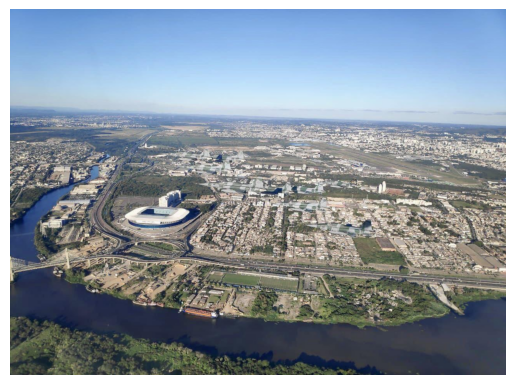

In [48]:
import matplotlib.pyplot as plt
from PIL import Image

# Load image
img = Image.open("./examples/fighter_jets.jpg")

# Show image
plt.imshow(img)
plt.axis("off")   # hide axes
plt.show()

In [49]:
pixel_values = load_image_from_url('https://image.cnbcfm.com/api/v1/image/107196244-1676618256129-An_Li.jpg?v=1676635561&w=1260&h=709&ffmt=webp&vtcrop=y', max_num=12).to(torch.bfloat16).cuda()


In [45]:
def prompt_from_url(image_url, question="Please describe the image in as much detail as possible"):
    question = '<image>\n'+ question

    headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"}
    
    response = requests.get(image_url, headers=headers)
    #print(response.content)
    img = Image.open(BytesIO(response.content))

    pixel_values = load_image_from_url(image_url, max_num=12).to(torch.bfloat16).cuda()

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')

    # Show image
    plt.imshow(img)
    plt.axis("off")   # hide axes
    plt.show()


In [46]:
def prompt_from_path(image_path, question="Please describe the image in as much detail as possible"):
    question = '<image>\n'+ question
    img = Image.open(image_path)

    pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')

    # Show image
    plt.imshow(img)
    plt.axis("off")   # hide axes
    plt.show()


User: <image>
Please describe the image in as much detail as possible
Assistant: The image is a black and white photograph depicting a vast, terraced landscape, likely a salt flat or salt pans. The terraces are arranged in a grid-like pattern, with each section filled with water. The water appears to be shallow, reflecting the sky and surrounding terrain. The terraces are bordered by earthen walls, creating a series of rectangular and square pools.

In the foreground, a person is visible, walking along one of the terraces. The person is small in comparison to the expansive landscape, emphasizing the scale of the terraces. The background features rugged, mountainous terrain, with steep slopes and a cloudy sky above. The mountains rise dramatically, adding a sense of depth and grandeur to the scene. The overall atmosphere is serene and somewhat desolate, with the monochromatic tones enhancing the timeless quality of the landscape.


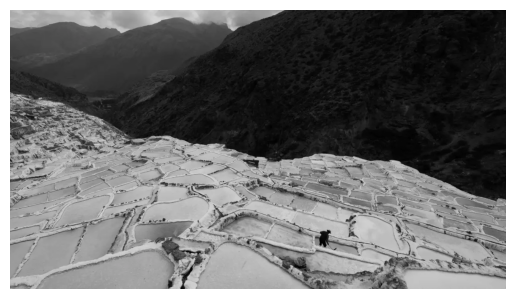

In [47]:
prompt_from_url("https://image.cnbcfm.com/api/v1/image/107196244-1676618256129-An_Li.jpg?v=1676635561&w=1260&h=709&ffmt=webp&vtcrop=y")

User: <image>
which is closer to the camera the eagle or the horse
Assistant: The eagle is closer to the camera.


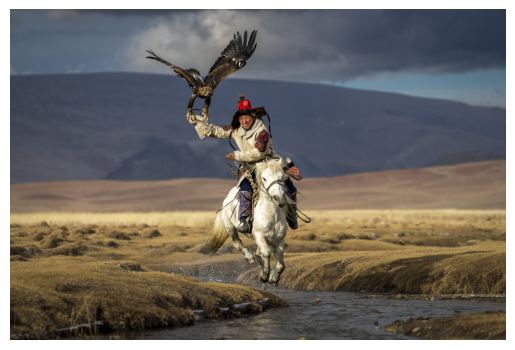

In [49]:
prompt_from_url("https://image.cnbcfm.com/api/v1/image/107196238-1676617601203-Eric_Esterle.jpg?v=1676635561",
               "which is closer to the camera the eagle or the horse")


User: <image>
please only describe the upper left quadrant of this image
Assistant: In the upper left quadrant of the image, there is a muscular individual posing on stage. The person is wearing a purple posing suit and has a focused expression. The background features a dark, geometric pattern with blue and white accents.


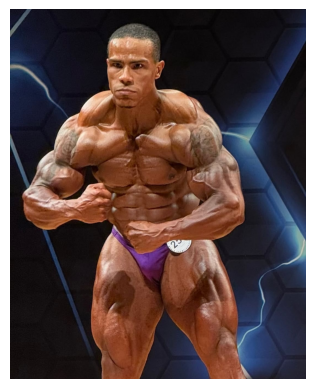

In [50]:
prompt_from_url(
    "https://substackcdn.com/image/fetch/$s_!3hGr!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F53b40458-0193-4299-a621-82598ae23fce_1080x1350.jpeg",
    "please only describe the upper left quadrant of this image")


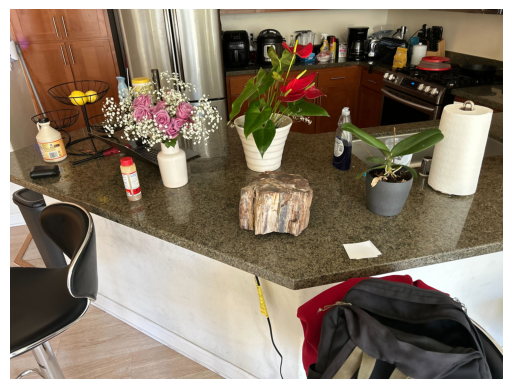

In [51]:
img = Image.open("../../local_datasets/IMG_4407.jpg")
plt.imshow(img)
plt.axis("off")   # hide axes
plt.show()

User: <image>
What type of plants are visible, be specific?
Assistant: In the image, there are several types of plants visible on the kitchen counter:

1. **Anthurium**: The plant with large, heart-shaped leaves and bright red flowers is an Anthurium. It is a popular houseplant known for its vibrant blooms and glossy foliage.

2. **Purple Roses**: The bouquet of flowers includes purple roses. Roses are a classic choice for floral arrangements and are known for their beauty and fragrance.

3. **White Baby's Breath**: The small white flowers in the bouquet are likely baby's breath (Gypsophila). This plant is often used in floral arrangements for its delicate, airy appearance.

4. **Green Plant in a Gray Pot**: There is a green plant in a gray pot, but the specific type of plant is not clearly identifiable from the image.

These plants add a touch of nature and color to the kitchen counter, creating a pleasant and inviting atmosphere.


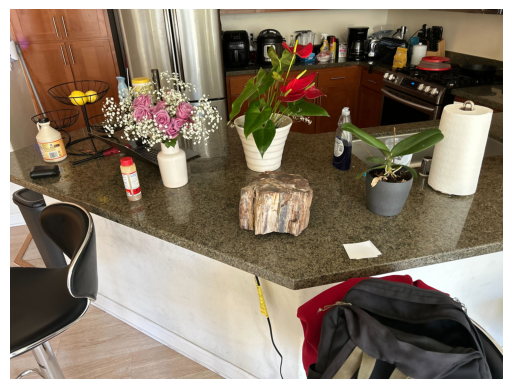

In [52]:
prompt_from_path("../../local_datasets/IMG_4407.jpg", "What type of plants are visible, be specific?"
                )


/home/dguillory/anaconda3/envs/elbiat/lib/python3.10/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


User: <image>
Estimate how many roses are in the image
Assistant: The image shows a large bouquet of red roses. Estimating the exact number is challenging, but there are likely around 50 to 60 roses in the bouquet.


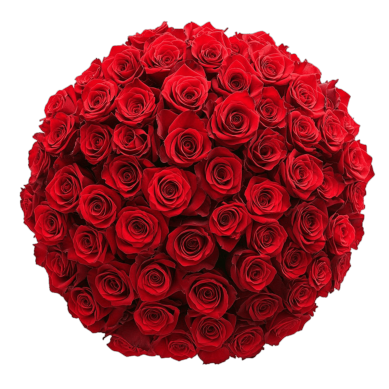

In [53]:
prompt_from_url(
    "https://cdn.globalrose.com/assets/img/prod/red-roses-for-valentines-day-globalrose.png",
    "Estimate how many roses are in the image")